In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

In [2]:
data = pd.read_excel("/Users/jacopobinati/Desktop/thesis/Datasets/paneldata_wdi_labor_gdp.xlsx")
data.head(10)

,Country,Year,CollectiveBargain_Coverage,TradeUnions_Density,Real Average Annual Wage Growth,Annual Inflation CPI,Gini Index,Employment/population ratio Women age 15 to 64,Labour force participation rate (Women age 15 to 64),Unemployment rate (Women age 15 to 64),...,Coverage of social protection and labor programs (% of population),Current health expenditure (% of GDP),Exports of goods and services (annual % growth),"Foreign direct investment, net inflows (% of GDP)","Foreign direct investment, net outflows (% of GDP)",Imports of goods and services (% of GDP),"Labor force, total",Labor tax and contributions (% of commercial profits),"Part time employment, total (% of total employment)",GDP (current US$)
0,Australia,1960,NaN,53.799999,NaN,3.728814,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14.037200,NaN,NaN,NaN,1.860656e+10
1,Australia,1961,92.000000,53.200001,NaN,2.287582,NaN,NaN,NaN,NaN,...,NaN,NaN,4.987326,NaN,NaN,14.999431,NaN,NaN,NaN,1.968288e+10
2,Australia,1962,NaN,51.400002,NaN,-0.319489,NaN,NaN,NaN,NaN,...,NaN,NaN,13.546493,NaN,NaN,12.609624,NaN,NaN,NaN,1.992256e+10
3,Australia,1963,NaN,49.700001,NaN,0.641026,NaN,NaN,NaN,NaN,...,NaN,NaN,-2.226884,NaN,NaN,13.810316,NaN,NaN,NaN,2.153984e+10
4,Australia,1964,90.699997,48.200001,NaN,2.866242,NaN,NaN,NaN,NaN,...,NaN,NaN,16.489846,NaN,NaN,13.740530,NaN,NaN,NaN,2.380112e+10
5,Australia,1965,NaN,47.900002,NaN,3.405573,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.262374,NaN,NaN,15.241668,NaN,NaN,NaN,2.597616e+10
6,Australia,1966,NaN,45.799999,NaN,3.293413,NaN,40.223370,41.328994,2.675176,...,NaN,NaN,1.451915,NaN,NaN,15.105406,NaN,NaN,NaN,2.730784e+10
7,Australia,1967,NaN,45.000000,NaN,3.478261,NaN,41.105927,42.313391,2.853622,...,NaN,NaN,10.965393,NaN,NaN,13.869983,NaN,NaN,NaN,3.044272e+10
8,Australia,1968,NaN,44.799999,NaN,2.521008,NaN,41.712722,42.928047,2.831073,...,NaN,NaN,4.801600,NaN,NaN,14.461296,NaN,NaN,NaN,3.271409e+10
9,Australia,1969,88.300003,44.400002,NaN,3.278688,NaN,42.185129,43.351996,2.691611,...,NaN,NaN,6.521879,NaN,NaN,13.311758,NaN,NaN,NaN,3.668337e+10


# Causal Map for the analysis

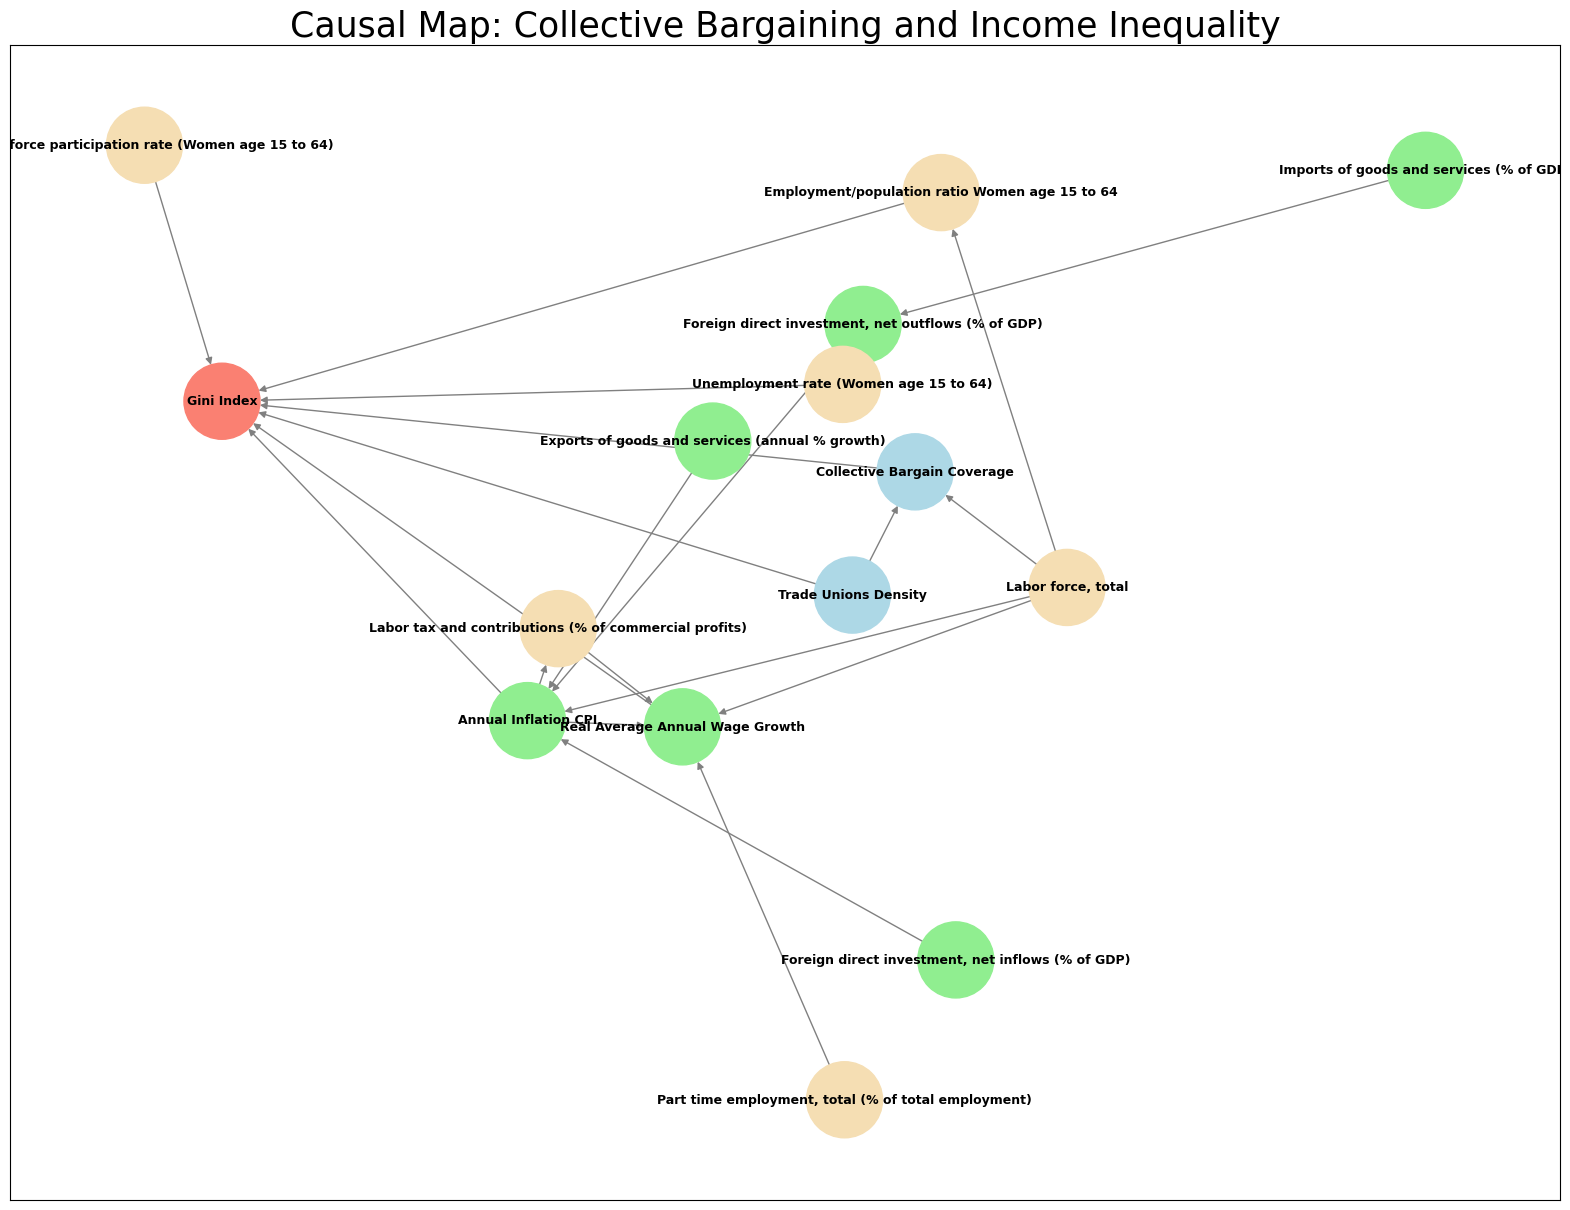

In [3]:
G = nx.DiGraph()

nodes_with_categories = {
    'Collective Bargain Coverage': 'Collective Bargaining',
    'Trade Unions Density': 'Collective Bargaining',
    'Gini Index': 'Income Inequality',
    'Real Average Annual Wage Growth': 'Economic',
    'Annual Inflation CPI': 'Economic',
    'Exports of goods and services (annual % growth)': 'Economic',
    'Foreign direct investment, net inflows (% of GDP)': 'Economic',
    'Foreign direct investment, net outflows (% of GDP)': 'Economic',
    'Imports of goods and services (% of GDP)': 'Economic',
    'Employment/population ratio Women age 15 to 64': 'Labor Market',
    'Labour force participation rate (Women age 15 to 64)': 'Labor Market',
    'Unemployment rate (Women age 15 to 64)': 'Labor Market',
    'Labor force, total': 'Labor Market',
    'Labor tax and contributions (% of commercial profits)': 'Labor Market',
    'Part time employment, total (% of total employment)': 'Labor Market'
}

for node in nodes_with_categories:
    G.add_node(node, category=nodes_with_categories[node])

edges = [
    ('Collective Bargain Coverage', 'Gini Index'),
    ('Trade Unions Density', 'Gini Index'),
    ('Trade Unions Density', 'Collective Bargain Coverage'),

    ('Real Average Annual Wage Growth', 'Gini Index'),

    ('Annual Inflation CPI', 'Gini Index'),
    ('Annual Inflation CPI', 'Real Average Annual Wage Growth'),
    ('Annual Inflation CPI', 'Labor tax and contributions (% of commercial profits)'),

    ('Employment/population ratio Women age 15 to 64', 'Gini Index'),

    ('Labour force participation rate (Women age 15 to 64)', 'Gini Index'),
    ('Unemployment rate (Women age 15 to 64)', 'Gini Index'),

    ('Labor tax and contributions (% of commercial profits)', 'Real Average Annual Wage Growth'),

    ('Part time employment, total (% of total employment)', 'Real Average Annual Wage Growth'),

    ('Labor force, total', 'Real Average Annual Wage Growth'),
    ('Labor force, total', 'Annual Inflation CPI'),
    ('Labor force, total', 'Collective Bargain Coverage'),
    ('Labor force, total', 'Employment/population ratio Women age 15 to 64'),

    ('Exports of goods and services (annual % growth)', 'Annual Inflation CPI'),

    ('Foreign direct investment, net inflows (% of GDP)', 'Annual Inflation CPI'),
    ('Foreign direct investment, net outflows (% of GDP)', 'Annual Inflation CPI'),

    ('Imports of goods and services (% of GDP)', 'Foreign direct investment, net outflows (% of GDP)')
]

G.add_edges_from(edges)

color_map = {
    'Collective Bargaining': 'lightblue',
    'Income Inequality': 'salmon',
    'Economic': 'lightgreen',
    'Labor Market': 'wheat'
}
node_colors = [color_map[G.nodes[node]['category']] for node in G.nodes]

# Draw the graph
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G, seed=6)
nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, edge_color='gray', node_size=3000, font_weight='bold', font_size=9)
plt.title('Causal Map: Collective Bargaining and Income Inequality', size=25)
plt.show()

# Data Cleaning

In [4]:
print(data['Country'].unique())

['Australia' 'Austria' 'Belgium' 'Canada' 'Chile' 'Czechia' 'Denmark'
 'Estonia' 'Finland' 'France' 'Germany' 'Greece' 'Hungary' 'Iceland'
 'Ireland' 'Israel' 'Italy' 'Japan' 'Latvia' 'Lithuania' 'Luxembourg'
 'Netherlands' 'New Zealand' 'Norway' 'Poland' 'Portugal'
 'Slovak Republic' 'Slovenia' 'Spain' 'Sweden' 'Switzerland'
 'United Kingdom' 'United States']


In [5]:
countries = ['Austria', 'Belgium', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom']
df = data[(data['Year'] >= 1990) & (data['Country'].isin(countries))]
df.head(10)

,Country,Year,CollectiveBargain_Coverage,TradeUnions_Density,Real Average Annual Wage Growth,Annual Inflation CPI,Gini Index,Employment/population ratio Women age 15 to 64,Labour force participation rate (Women age 15 to 64),Unemployment rate (Women age 15 to 64),...,Coverage of social protection and labor programs (% of population),Current health expenditure (% of GDP),Exports of goods and services (annual % growth),"Foreign direct investment, net inflows (% of GDP)","Foreign direct investment, net outflows (% of GDP)",Imports of goods and services (% of GDP),"Labor force, total",Labor tax and contributions (% of commercial profits),"Part time employment, total (% of total employment)",GDP (current US$)
93,Austria,1990,NaN,46.799999,NaN,3.261872,NaN,NaN,NaN,NaN,...,NaN,NaN,8.572220,0.392278,1.021846,35.790955,NaN,NaN,NaN,1.664634e+11
94,Austria,1991,98.0,45.500000,3.125859,3.337426,NaN,NaN,NaN,NaN,...,NaN,NaN,2.937296,0.207142,0.743983,35.457917,3569407.0,NaN,NaN,1.737942e+11
95,Austria,1992,NaN,44.500000,2.014635,4.020847,NaN,NaN,NaN,NaN,...,NaN,NaN,1.319386,0.761499,0.902222,34.474900,3652067.0,NaN,NaN,1.950781e+11
96,Austria,1993,NaN,44.000000,0.815329,3.631786,NaN,NaN,NaN,NaN,...,NaN,NaN,-2.373161,0.590980,0.619051,31.801153,3684501.0,NaN,NaN,1.903797e+11
97,Austria,1994,NaN,41.500000,1.007529,2.953407,30.8,NaN,61.315422,4.012873,...,NaN,NaN,5.688089,1.019884,0.609730,33.828559,3851283.0,NaN,NaN,2.035352e+11
98,Austria,1995,NaN,41.099998,0.805614,2.243364,29.9,NaN,61.578041,4.392549,...,NaN,NaN,7.205394,0.757179,0.449536,34.723461,3882088.0,NaN,20.40,2.410383e+11
99,Austria,1996,98.0,40.099998,-0.661107,1.860974,29.3,NaN,61.042473,4.512449,...,NaN,NaN,4.638488,1.822338,0.796237,35.834395,3852167.0,NaN,20.05,2.372509e+11
100,Austria,1997,NaN,38.900002,-0.862231,1.305983,29.1,NaN,61.311236,4.705196,...,NaN,NaN,11.027821,1.254274,0.939127,37.839607,3837968.0,NaN,18.21,2.127903e+11
101,Austria,1998,NaN,38.400002,3.227776,0.922467,31.3,NaN,61.390793,4.649185,...,NaN,NaN,7.851485,2.094684,1.268233,38.576128,3877122.0,NaN,23.73,2.182599e+11
102,Austria,1999,NaN,37.900002,2.234816,0.568986,29.7,NaN,61.778667,3.887604,...,NaN,NaN,6.433960,1.369102,1.519343,38.903102,3902046.0,NaN,23.76,2.172591e+11


In [6]:
(df.isnull().sum() / len(df)) * 100
df.to_excel('2_paneldata_wdi_labor_gdp.xlsx', index=False)

# Treatment and Control Groups

in order to have a treatment and control groups, I will take countries in EU with an effective minimum wage and controls will be countries without a minimum wage. and in order to ballance countries in both treatment and control group I will use average GDP from 1990 until 2022 to match in size.

Countries with a minimum wage:
- Germany
- France
- Spain
- Belgium
- Slovakia
- Nethrlands
- Luxemburg
- Portugal

Countries without a minimum wage:
- Austria
- Italy
- Denmark
- Finland
- Sweden
- Norway

### Merging the minimum wage with the panel data

In [7]:
minimum_wage_cleaned_path = '/Users/jacopobinati/Desktop/thesis/2_paneldata_wdi_labor_gdp.xlsx'
paneldata_wdi_labor_gdp_path = '/Users/jacopobinati/Desktop/thesis/minimum wage/minimum_wage_cleaned_PD.xlsx'

minimum_wage_cleaned = pd.read_excel(minimum_wage_cleaned_path)
paneldata_wdi_labor_gdp = pd.read_excel(paneldata_wdi_labor_gdp_path)

# Merge on 'Country' and 'Year'
merged_data = pd.merge(paneldata_wdi_labor_gdp, minimum_wage_cleaned, on=['Country', 'Year'], how='outer')

# Fill missing values with 0
merged_data['Real Minimum Wage'] = merged_data['Real Minimum Wage'].fillna(0)

In [8]:
merged_data['Monthly Minimum Wage'] = merged_data['Monthly Minimum Wage'].fillna(0)
merged_data['Country'].unique()

array(['Belgium', 'France', 'Germany', 'Hungary', 'Ireland', 'Luxembourg',
       'Netherlands', 'Poland', 'Portugal', 'Slovak Republic', 'Spain',
       'Croatia', 'Romania', 'Austria', 'Czechia', 'Denmark', 'Estonia',
       'Finland', 'Greece', 'Iceland', 'Italy', 'Latvia', 'Lithuania',
       'Norway', 'Slovenia', 'Sweden', 'Switzerland', 'United Kingdom'],
      dtype=object)

In [9]:
merged_data.to_excel('/Users/jacopobinati/Desktop/thesis/Datasets/merged_data.xlsx', index=False)

# Creating treatment and control based on minimum wage

In [10]:
df1 = merged_data
df1['Country'].unique()

array(['Belgium', 'France', 'Germany', 'Hungary', 'Ireland', 'Luxembourg',
       'Netherlands', 'Poland', 'Portugal', 'Slovak Republic', 'Spain',
       'Croatia', 'Romania', 'Austria', 'Czechia', 'Denmark', 'Estonia',
       'Finland', 'Greece', 'Iceland', 'Italy', 'Latvia', 'Lithuania',
       'Norway', 'Slovenia', 'Sweden', 'Switzerland', 'United Kingdom'],
      dtype=object)

## Now let's check for average GDP and creating balanced control and treatment groups based on average GDP

In [11]:
average_gdp = df1.groupby('Country')['GDP (current US$)'].mean()
log_average_gdp = np.log(average_gdp)
log_average_gdp

Country
Austria            26.503843
Belgium            26.694102
Croatia                  NaN
Czechia            25.716937
Denmark            26.292178
Estonia            23.653546
Finland            26.032909
France             28.391624
Germany            28.723749
Greece             26.017486
Hungary            25.368022
Iceland            23.397686
Ireland            26.077212
Italy              28.168252
Latvia             23.832669
Lithuania          24.261492
Luxembourg         24.497150
Netherlands        27.230828
Norway             26.467542
Poland             26.578872
Portugal           25.921036
Romania                  NaN
Slovak Republic    24.897322
Slovenia           24.423446
Spain              27.674898
Sweden             26.745142
Switzerland        26.933160
United Kingdom     28.427702
Name: GDP (current US$), dtype: float64

In [12]:
df1 = df1[~((df1['Country'] == 'Romania') | (df1['Country'] == 'Croatia'))]
df1['Country'].unique()

array(['Belgium', 'France', 'Germany', 'Hungary', 'Ireland', 'Luxembourg',
       'Netherlands', 'Poland', 'Portugal', 'Slovak Republic', 'Spain',
       'Austria', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'Greece',
       'Iceland', 'Italy', 'Latvia', 'Lithuania', 'Norway', 'Slovenia',
       'Sweden', 'Switzerland', 'United Kingdom'], dtype=object)

In [13]:
df1

,Country,Year,Real Minimum Wage,Monthly Minimum Wage,CollectiveBargain_Coverage,TradeUnions_Density,Real Average Annual Wage Growth,Annual Inflation CPI,Gini Index,Employment/population ratio Women age 15 to 64,...,Coverage of social protection and labor programs (% of population),Current health expenditure (% of GDP),Exports of goods and services (annual % growth),"Foreign direct investment, net inflows (% of GDP)","Foreign direct investment, net outflows (% of GDP)",Imports of goods and services (% of GDP),"Labor force, total",Labor tax and contributions (% of commercial profits),"Part time employment, total (% of total employment)",GDP (current US$)
0,Belgium,1990,26202.014218,2183.501185,NaN,50.599998,NaN,3.448310,NaN,NaN,...,NaN,NaN,4.573915,3.918892,3.075238,59.854160,NaN,NaN,18.24,2.053317e+11
1,France,1990,20145.492469,1678.791039,NaN,10.700000,NaN,3.194282,32.1,NaN,...,NaN,NaN,4.145828,1.038725,2.743777,21.760322,NaN,NaN,23.43,1.269180e+12
2,Germany,1990,0.000000,0.000000,NaN,31.200001,NaN,2.696470,NaN,NaN,...,NaN,NaN,11.348747,0.144310,1.356736,23.027751,NaN,NaN,20.52,1.771671e+12
3,Hungary,1990,5291.874409,440.989534,NaN,88.599998,NaN,28.369590,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ireland,1990,0.000000,0.000000,NaN,51.099998,NaN,3.317329,NaN,NaN,...,NaN,NaN,8.729924,1.261339,0.738017,50.323209,NaN,NaN,17.83,4.930563e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,United Kingdom,2018,0.000000,0.000000,26.0,23.400000,0.900000,2.300000,33.7,NaN,...,NaN,9.658155,3.086065,-0.872604,-0.997170,32.962537,34415434.0,10.8,41.71,2.871340e+12
920,United Kingdom,2019,0.000000,0.000000,26.0,23.500000,1.400000,1.700000,32.8,NaN,...,NaN,9.874801,1.996940,0.694070,-0.753954,33.030353,34695933.0,12.0,41.11,2.851407e+12
921,United Kingdom,2020,0.000000,0.000000,26.9,NaN,-2.000000,1.000000,32.6,NaN,...,NaN,11.977593,-11.469713,4.910509,-0.164757,29.082569,34633314.0,NaN,NaN,2.697807e+12
922,United Kingdom,2021,0.000000,0.000000,NaN,NaN,2.144810,2.500000,NaN,NaN,...,NaN,11.939087,4.941180,0.188516,5.122765,29.751335,34311328.0,NaN,NaN,3.141506e+12


In [14]:
unique_countries = df1['Country'].unique()
print(unique_countries)

['Belgium' 'France' 'Germany' 'Hungary' 'Ireland' 'Luxembourg'
 'Netherlands' 'Poland' 'Portugal' 'Slovak Republic' 'Spain' 'Austria'
 'Czechia' 'Denmark' 'Estonia' 'Finland' 'Greece' 'Iceland' 'Italy'
 'Latvia' 'Lithuania' 'Norway' 'Slovenia' 'Sweden' 'Switzerland'
 'United Kingdom']


In [15]:
df1.to_excel('Data Finale1.xlsx', index=False)

# Handling Missing data

In [16]:
df3 = pd.read_excel('/Users/jacopobinati/Desktop/thesis/Data Finale1.xlsx')
df3.head()

,Country,Year,Real Minimum Wage,Monthly Minimum Wage,CollectiveBargain_Coverage,TradeUnions_Density,Real Average Annual Wage Growth,Annual Inflation CPI,Gini Index,Employment/population ratio Women age 15 to 64,...,Coverage of social protection and labor programs (% of population),Current health expenditure (% of GDP),Exports of goods and services (annual % growth),"Foreign direct investment, net inflows (% of GDP)","Foreign direct investment, net outflows (% of GDP)",Imports of goods and services (% of GDP),"Labor force, total",Labor tax and contributions (% of commercial profits),"Part time employment, total (% of total employment)",GDP (current US$)
0,Belgium,1990,26202.014218,2183.501185,NaN,50.599998,NaN,3.448310,NaN,NaN,...,NaN,NaN,4.573915,3.918892,3.075238,59.854160,NaN,NaN,18.24,2.053317e+11
1,France,1990,20145.492469,1678.791039,NaN,10.700000,NaN,3.194282,32.1,NaN,...,NaN,NaN,4.145828,1.038725,2.743777,21.760322,NaN,NaN,23.43,1.269180e+12
2,Germany,1990,0.000000,0.000000,NaN,31.200001,NaN,2.696470,NaN,NaN,...,NaN,NaN,11.348747,0.144310,1.356736,23.027751,NaN,NaN,20.52,1.771671e+12
3,Hungary,1990,5291.874409,440.989534,NaN,88.599998,NaN,28.369590,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ireland,1990,0.000000,0.000000,NaN,51.099998,NaN,3.317329,NaN,NaN,...,NaN,NaN,8.729924,1.261339,0.738017,50.323209,NaN,NaN,17.83,4.930563e+10


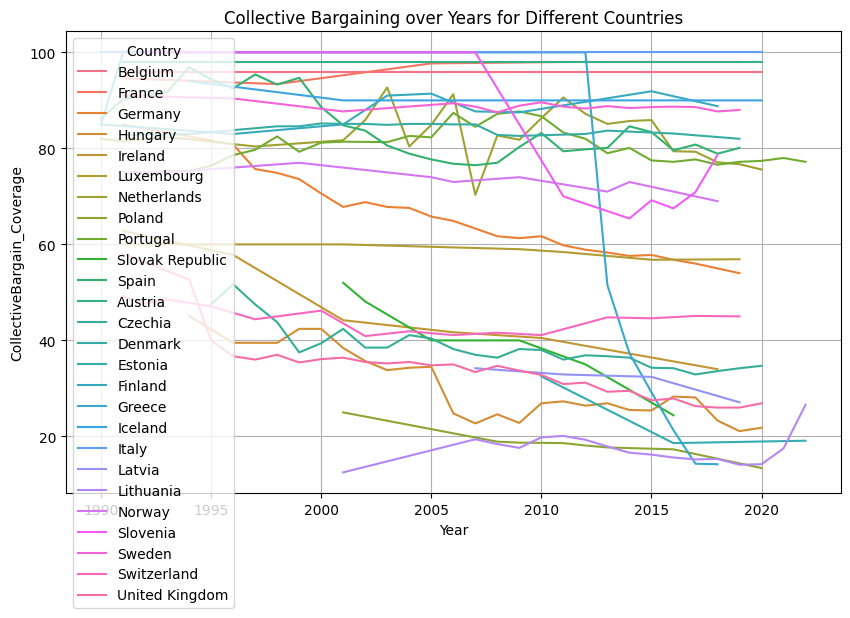

In [17]:
data1 = df3.copy()
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='CollectiveBargain_Coverage', hue='Country', data=data1)
plt.title('Collective Bargaining over Years for Different Countries')
plt.grid()
plt.show()

In [18]:
df3.sort_values(by=['Country', 'Year'], inplace=True)

In [19]:
variables = [
    "CollectiveBargain_Coverage",
    "TradeUnions_Density",
    "Real Average Annual Wage Growth",
    "Gini Index",
    "Labour force participation rate (Women age 15 to 64)",
    "Unemployment rate (Women age 15 to 64)",
    "Central government debt, total (% of GDP)",
    "Children out of school, primary",
    "Current health expenditure (% of GDP)",
    "Foreign direct investment, net inflows (% of GDP)",
    "Foreign direct investment, net outflows (% of GDP)",
    "Labor force, total",
    "Labor tax and contributions (% of commercial profits)",
    "Part time employment, total (% of total employment)",
    "Annual Inflation CPI",
    "Central government debt, total (% of GDP)",
    "Exports of goods and services (annual % growth)",
    "Imports of goods and services (% of GDP)",
    "GDP (current US$)"
]

for variable in variables:
    # Forward Fill within each country
    df3[variable] = df3.groupby('Country')[variable].ffill()
    # Backward Fill within each country
    df3[variable] = df3.groupby('Country')[variable].bfill()
    # Interpolation within each country
    df3[variable] = df3.groupby('Country')[variable].transform(lambda group: group.interpolate())
    # Fill with mean within each country (only for variables where this makes sense)
    df3[variable] = df3.groupby('Country')[variable].transform(lambda group: group.fillna(group.mean()))

In [20]:
# round all the values to 2 decimal places except treatment and control
cols = [col for col in df3.columns if col not in ['treatment', 'control']]
df3[cols] = df3[cols].round(2)

In [21]:
df3 = df3[df3['Country'] != 'Latvia']
df3 = df3[df3['Country'] != 'Slovenia']

In [22]:
df3.drop('Employment/population ratio Women age 15 to 64', inplace=True, axis=1)
df3.drop('Coverage of social protection and labor programs (% of population)', inplace=True, axis=1)
df3.drop('Real Minimum Wage', inplace=True, axis=1)

df3.to_excel('Data Finale_balanced1.xlsx', index=False)


In [23]:
df3

,Country,Year,Monthly Minimum Wage,CollectiveBargain_Coverage,TradeUnions_Density,Real Average Annual Wage Growth,Annual Inflation CPI,Gini Index,Labour force participation rate (Women age 15 to 64),Unemployment rate (Women age 15 to 64),...,"Children out of school, primary",Current health expenditure (% of GDP),Exports of goods and services (annual % growth),"Foreign direct investment, net inflows (% of GDP)","Foreign direct investment, net outflows (% of GDP)",Imports of goods and services (% of GDP),"Labor force, total",Labor tax and contributions (% of commercial profits),"Part time employment, total (% of total employment)",GDP (current US$)
363,Austria,1990,0.0,98.0,46.8,3.13,3.26,30.8,61.32,4.01,...,4616.0,9.20,8.57,0.39,1.02,35.79,3569407.0,35.3,20.40,1.664634e+11
364,Austria,1991,0.0,98.0,45.5,3.13,3.34,30.8,61.32,4.01,...,4616.0,9.20,2.94,0.21,0.74,35.46,3569407.0,35.3,20.40,1.737942e+11
365,Austria,1992,0.0,98.0,44.5,2.01,4.02,30.8,61.32,4.01,...,4616.0,9.20,1.32,0.76,0.90,34.47,3652067.0,35.3,20.40,1.950781e+11
366,Austria,1993,0.0,98.0,44.0,0.82,3.63,30.8,61.32,4.01,...,4616.0,9.20,-2.37,0.59,0.62,31.80,3684501.0,35.3,20.40,1.903797e+11
367,Austria,1994,0.0,98.0,41.5,1.01,2.95,30.8,61.32,4.01,...,4616.0,9.20,5.69,1.02,0.61,33.83,3851283.0,35.3,20.40,2.035352e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,United Kingdom,2018,0.0,26.0,23.4,0.90,2.30,33.7,73.55,4.19,...,116634.0,9.66,3.09,-0.87,-1.00,32.96,34415434.0,10.8,41.71,2.871340e+12
854,United Kingdom,2019,0.0,26.0,23.5,1.40,1.70,32.8,74.37,3.72,...,122703.0,9.87,2.00,0.69,-0.75,33.03,34695933.0,12.0,41.11,2.851407e+12
855,United Kingdom,2020,0.0,26.9,23.5,-2.00,1.00,32.6,74.99,4.35,...,150458.0,11.98,-11.47,4.91,-0.16,29.08,34633314.0,12.0,41.11,2.697807e+12
856,United Kingdom,2021,0.0,26.9,23.5,2.14,2.50,32.6,74.67,4.30,...,1026.0,11.94,4.94,0.19,5.12,29.75,34311328.0,12.0,41.11,3.141506e+12
